In [2]:
import polars as pl
import matplotlib.pyplot as plt
file_path = r'C:\Users\ramya\Downloads\openpolicing.parquet'
lf = pl.scan_parquet(file_path)

Basic Question: Can geographic/location data show disparities in outcomes?

Do some counties conduct more searches than others?

In [70]:
# creating a data frame that only contains the columns i am currently analyzing

clean = lf.select(['county_name', 'search_conducted']).drop_nulls().collect()
clean = clean.with_columns((pl.col('search_conducted') == 'TRUE').cast(pl.Int8).alias('search_conducted_int'))
clean


county_name,search_conducted,search_conducted_int
str,str,i8
"""Guilford County""","""FALSE""",0
"""Guilford County""","""FALSE""",0
"""Guilford County""","""FALSE""",0
"""Guilford County""","""FALSE""",0
"""Guilford County""","""FALSE""",0
…,…,…
"""Jackson County""","""FALSE""",0
"""Jackson County""","""FALSE""",0
"""Jackson County""","""FALSE""",0


In [71]:
# where are searches being conducted the most?

temp = clean.filter(pl.col('search_conducted') == 'TRUE')
temp

county_name,search_conducted,search_conducted_int
str,str,i8
"""Guilford County""","""TRUE""",1
"""Guilford County""","""TRUE""",1
"""Guilford County""","""TRUE""",1
"""Guilford County""","""TRUE""",1
"""Guilford County""","""TRUE""",1
…,…,…
"""Wake County""","""TRUE""",1
"""Hoke County""","""TRUE""",1
"""Hoke County""","""TRUE""",1


In [ ]:
# summing up the number of searches per county using the .group_by() and .agg() to apply this to all the rows fast

search_true = temp.group_by('county_name').agg(pl.col('search_conducted_int').sum().alias('search_count'))
search_true

([<matplotlib.patches.Wedge at 0x23d7e958390>,
 [Text(1.099991718494506, 0.004268400579047229, 'Hertford County'),
  Text(1.097430594821109, 0.07514046546693061, 'Hamilton County'),
  Text(1.0820308905529248, 0.19801300939393995, 'Lorain County'),
  Text(1.0639000331005215, 0.27949368430916216, 'Yolo'),
  Text(1.0549905664705066, 0.3114400498623124, 'Davie County'),
  Text(1.0473344312313764, 0.33628944253016574, 'Polk County'),
  Text(1.0302812122623808, 0.3853837355924082, 'Van Zandt County'),
  Text(1.0155641190868037, 0.4226458565080753, 'Defiance County'),
  Text(1.0127562587999375, 0.42933059553397124, 'Broadwater County'),
  Text(1.0103451344199101, 0.43497437781323844, 'Lampasas County'),
  Text(1.0076389967663966, 0.44120704005671774, 'Mineral County'),
  Text(0.9990900457974161, 0.46023806925168315, 'Hancock County'),
  Text(0.9814933813665686, 0.4966595839542612, 'Bexar County'),
  Text(0.9610552967488577, 0.5351380350815715, 'Kittitas County'),
  Text(0.9263333598085558, 0.

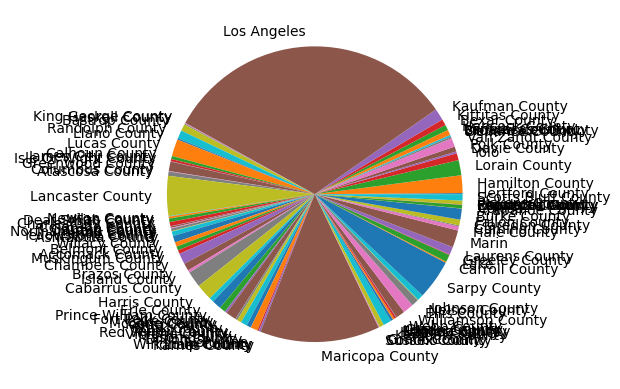

In [ ]:
# used a pie to sort of show the distribution of searches conducted in a sample 100 counties

county_name = search_true.select('county_name').slice(0,100).to_numpy().flatten()
search_count = search_true.select('search_count').slice(0,100).to_numpy().flatten()

plt.pie(search_count, labels=county_name)

In [ ]:
# now to further analyze i want to use the counties largest and smallest searches and look into why
# therefore, i used to .sort() to sort the dataframe from most searches to least

search_true = search_true.sort('search_count', descending=True)
search_true

county_name,search_count
str,i64
"""Mecklenburg County""",197173
"""Los Angeles""",193410
"""Wake County""",95799
"""Guilford County""",87160
"""Maricopa County""",78448
…,…
"""Sedgwick County""",1
"""Treasure County""",1
"""Teton County""",1


<BarContainer object of 4 artists>

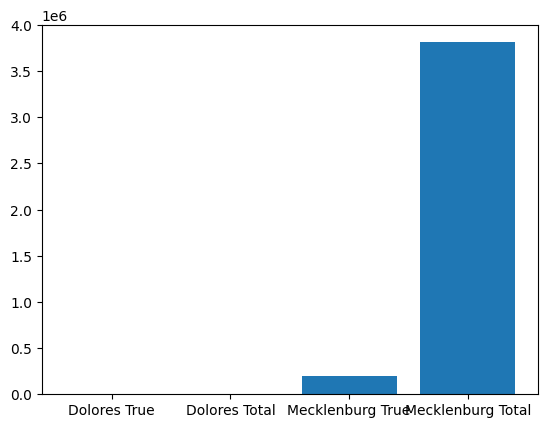

In [ ]:
# i picked the county with the most and least searches and tried to compare the total rows and the searches per each county
# the comparison is so large you can't see the number of searchest for the county with the lowest but it does in fact exist

dolores_county = clean.filter(pl.col('county_name') == 'Dolores County')
mecklenburg_county = clean.filter(pl.col('county_name') == 'Mecklenburg County')
dolores_acc = dolores_county.shape[0]
dolores_search = search_true.filter(pl.col('county_name') == 'Dolores County').select('search_count').to_numpy().item()
mecklenburg_acc = mecklenburg_county.shape[0]
mecklenburg_search = search_true.filter(pl.col('county_name') == 'Mecklenburg County').select('search_count').to_numpy().item()

labels = ['Dolores True', 'Dolores Total', 'Mecklenburg True', 'Mecklenburg Total']
data = [dolores_search, dolores_acc, mecklenburg_search, mecklenburg_acc]

plt.bar(labels, data)

<BarContainer object of 2 artists>

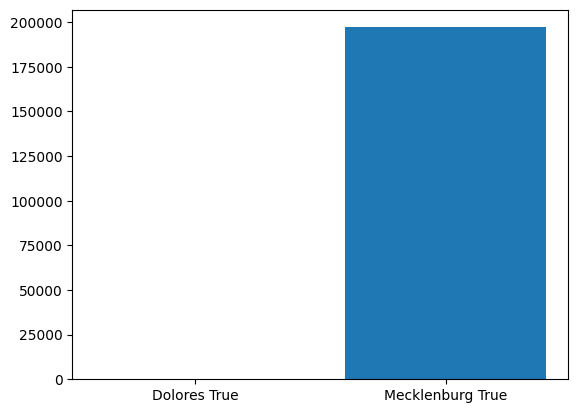

In [ ]:
labels = ['Dolores True', 'Mecklenburg True']
data = [dolores_search, mecklenburg_search]

plt.bar(labels, data)

([<matplotlib.patches.Wedge at 0x23d84135790>,
 [Text(1.0999963316547765, 0.002840835446673645, 'Dolores Total'),
  Text(-1.0999963314930687, -0.0028408980606270846, 'Mecklenburg Total')])

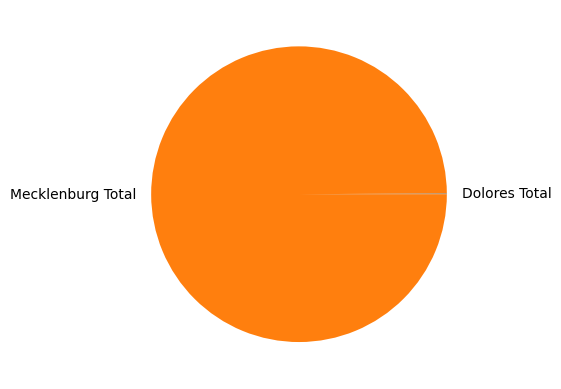

In [ ]:
labels = ['Dolores Total', 'Mecklenburg Total']
data = [dolores_acc, mecklenburg_acc]

plt.pie(data, labels=labels)

MOST SEARCHES: Mecklenburg County (197,173), Los Angeles (193,410), Wake County (95,799), Guilford County (87,160)


LEAST SEARCHES: Treasure County (1), Teton County (1), Bent County (1), Dolores County (1)

In [ ]:
# what types of searches were most conducted in the counties with the most searches?

clean = lf.select(['county_name','search_person', 'search_vehicle']).drop_nulls().collect()
clean

county_name,search_person,search_vehicle
str,str,str
"""Guilford County""","""FALSE""","""FALSE"""
"""Guilford County""","""FALSE""","""FALSE"""
"""Guilford County""","""FALSE""","""FALSE"""
"""Guilford County""","""FALSE""","""FALSE"""
"""Guilford County""","""FALSE""","""FALSE"""
…,…,…
"""Jackson County""","""FALSE""","""FALSE"""
"""Jackson County""","""FALSE""","""FALSE"""
"""Jackson County""","""FALSE""","""FALSE"""


In [ ]:
search_types = clean.group_by('county_name').agg(
    (pl.col('search_person') == 'TRUE').sum().alias('person_count'),
    (pl.col('search_vehicle') == 'TRUE').sum().alias('vehicle_count')
)
search_types

county_name,person_count,vehicle_count
str,u32,u32
"""Horry County""",22743,14619
"""Chesterfield County""",2268,1838
"""Gates County""",172,267
"""Walworth County""",21,23
"""Lancaster County""",5445,4737
…,…,…
"""0 County""",0,0
"""Cherokee County""",7081,6377
"""Darlington County""",6701,5574


Text(0.5, 1.0, 'Mecklenburg Search Types')

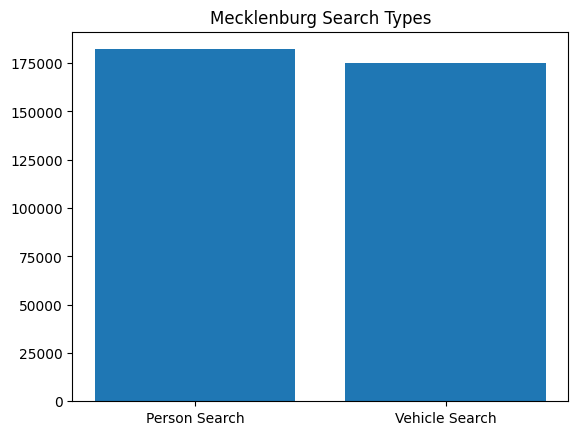

In [ ]:
meck_county = search_types.filter(pl.col('county_name') == 'Mecklenburg County')
meck_person_count = meck_county.select('person_count').to_numpy().item()
meck_vehicle_count = meck_county.select('vehicle_count').to_numpy().item()

plt.bar(['Person Search', 'Vehicle Search'], [meck_person_count, meck_vehicle_count])
plt.title('Mecklenburg Search Types')

Text(0.5, 1.0, 'Wake County Search Types')

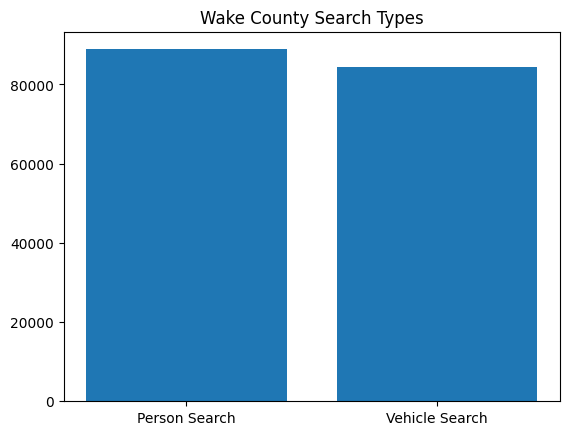

In [ ]:
wake_county = search_types.filter(pl.col('county_name') == 'Wake County')
wake_person_count = wake_county.select('person_count').to_numpy().item()
wake_vehicle_count = wake_county.select('vehicle_count').to_numpy().item()

plt.bar(['Person Search', 'Vehicle Search'], [wake_person_count, wake_vehicle_count])
plt.title('Wake County Search Types')

Text(0.5, 1.0, 'Guilford County Search Types')

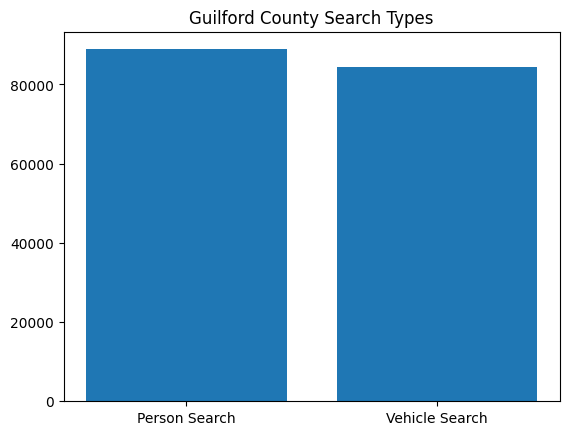

In [ ]:
guil_county = search_types.filter(pl.col('county_name') == 'Wake County')
guil_person_count = guil_county.select('person_count').to_numpy().item()
guil_vehicle_count = guil_county.select('vehicle_count').to_numpy().item()

plt.bar(['Person Search', 'Vehicle Search'], [guil_person_count, guil_vehicle_count])
plt.title('Guilford County Search Types')

In [ ]:
# los angeles has no cells which is interesting

la = search_types.filter(pl.col('county_name') == 'Los Angeles')
la

county_name,person_count,vehicle_count
str,u32,u32


In [ ]:
la_cells = lf.filter(pl.col('county_name') == 'Los Angeles').collect()
la_cells

date,time,location,county_name,subject_age,subject_race,subject_sex,officer_id_hash,department_name,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,frisk_performed,search_conducted,search_person,search_vehicle,search_basis,reason_for_frisk,reason_for_search,reason_for_stop,violation,vehicle_color,vehicle_make,vehicle_model,vehicle_registration_state,vehicle_year,service_area,officer_race,lat,lng,geocode_source,beat,division,officer_sex,disposition,posted_speed,district,precinct,speed,contraband_other,vehicle_type,officer_age,officer_years_of_service,unit,notes,sector,subsector,officer_assignment,use_of_force_description,department_id,contraband_alcohol,zone,region,neighborhood,reporting_area,reason_for_arrest,subdistrict,police_grid_number,use_of_force_reason,charged_speed,subdivision,substation
date,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f32,f32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
2009-07-04,null,null,"""Los Angeles""",null,"""hispanic""","""male""",null,"""California Highway Patrol""","""vehicular""","""FALSE""","""FALSE""","""FALSE""","""summons""",null,null,null,null,"""FALSE""","""FALSE""",null,null,null,null,"""Mechanical or Nonmoving Violat…","""Mechanical or Nonmoving Violat…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""West Los Angeles""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2009-07-04,null,null,"""Los Angeles""",null,"""white""","""male""",null,"""California Highway Patrol""","""vehicular""","""FALSE""","""FALSE""","""FALSE""","""summons""",null,null,null,null,"""FALSE""","""FALSE""",null,null,null,null,"""Moving Violation (VC)""","""Moving Violation (VC)""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""West Los Angeles""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2009-07-04,null,null,"""Los Angeles""",null,"""hispanic""","""male""",null,"""California Highway Patrol""","""vehicular""",null,null,null,null,null,null,null,null,"""FALSE""","""FALSE""",null,null,null,null,"""Motorist / Public Service""","""Motorist / Public Service""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""West Los Angeles""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2009-07-04,null,null,"""Los Angeles""",null,"""black""","""male""",null,"""California Highway Patrol""","""vehicular""",null,null,null,null,null,null,null,null,"""FALSE""","""FALSE""",null,null,null,null,"""Motorist / Public Service""","""Motorist / Public Service""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""West Los Angeles""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2009-07-04,null,null,"""Los Angeles""",null,"""black""","""male""",null,"""California Highway Patrol""","""vehicular""",null,null,null,null,null,null,null,null,"""FALSE""","""FALSE""",null,null,null,null,"""Motorist / Public Service""","""Motorist / Public Service""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""West Los Angeles""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016-06-30,null,null,"""Los Angeles""",null,"""asian/pacific islander""","""male""",null,"""California Highway Patrol""","""vehicular""","""TRUE""","""FALSE""","""FALSE""","""arrest""",null,null,null,null,"""

In [ ]:
options = {}
columns = ['search_person', 'search_vehicle']
for col in columns:
    val = la_cells.select(pl.col(col).unique())
    options[col] = val
options

{'search_person': shape: (3, 1)
 ┌───────────────┐
 │ search_person │
 │ ---           │
 │ str           │
 ╞═══════════════╡
 │ FALSE         │
 │ null          │
 │ TRUE          │
 └───────────────┘,
 'search_vehicle': shape: (1, 1)
 ┌────────────────┐
 │ search_vehicle │
 │ ---            │
 │ str            │
 ╞════════════════╡
 │ null           │
 └────────────────┘}

In [ ]:
la_cells = la_cells.select(['county_name', 'search_conducted', 'search_person'])
la_filtered = la_cells.group_by('county_name').agg(
    (pl.col('search_conducted') == 'TRUE').sum().alias('search_count'),
    (pl.col('search_person') == 'TRUE').sum().alias('person_count')
)
la_filtered

county_name,search_count,person_count
str,u32,u32
"""Los Angeles""",193410,11034


Text(0.5, 1.0, 'Los Angeles Search Data')

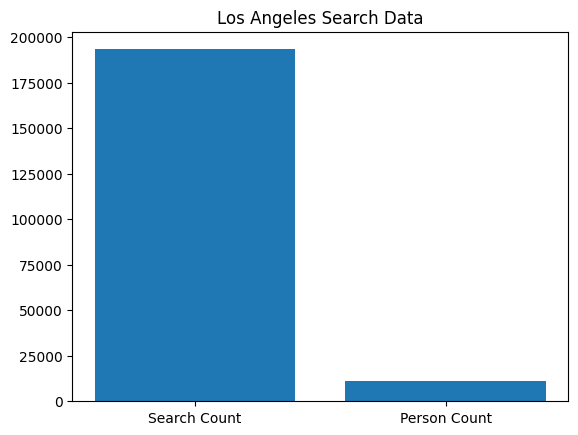

In [ ]:
# question: why is the search person so small in comparison to the amount of searches conducted? what other types of searches were done that is not stated?
# do they not have cars?

plt.bar(['Search Count', 'Person Count'], [193410, 11034])
plt.title('Los Angeles Search Data')

In [ ]:
# in the 4 most searched counties, is there a pattern or observation to make in the search basis?

search_reasons = lf.select(['county_name', 'search_basis']).drop_nulls().collect()
search_reasons

county_name,search_basis
str,str
"""Guilford County""","""other"""
"""Guilford County""","""probable cause"""
"""Guilford County""","""other"""
"""Guilford County""","""consent"""
"""Guilford County""","""consent"""
…,…
"""Wake County""","""probable cause"""
"""Hoke County""","""other"""
"""Hoke County""","""probable cause"""


Text(0.5, 1.0, 'Mecklenburg County Search Basis Data')

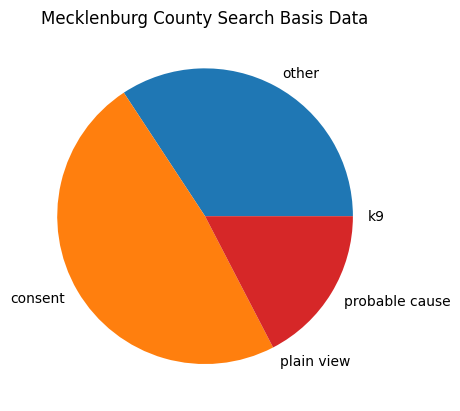

In [ ]:
meck_county = search_reasons.filter(pl.col('county_name') == 'Mecklenburg County')
labels = ['other', 'consent', 'plain view', 'probable cause', 'k9']
data = []
for label in labels:
    val = meck_county.filter(pl.col('search_basis') == label).shape[0]
    data.append(val)

plt.pie(data, labels=labels)
plt.title('Mecklenburg County Search Basis Data')

Text(0.5, 1.0, 'Los Angeles Search Basis Data')

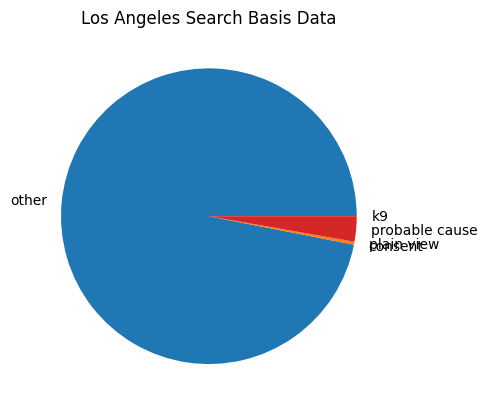

In [ ]:
la = search_reasons.filter(pl.col('county_name') == 'Los Angeles')
labels = ['other', 'consent', 'plain view', 'probable cause', 'k9']
data = []
for label in labels:
    val = la.filter(pl.col('search_basis') == label).shape[0]
    data.append(val)

plt.pie(data, labels=labels)
plt.title('Los Angeles Search Basis Data')

Text(0.5, 1.0, 'Wake County Search Basis Data')

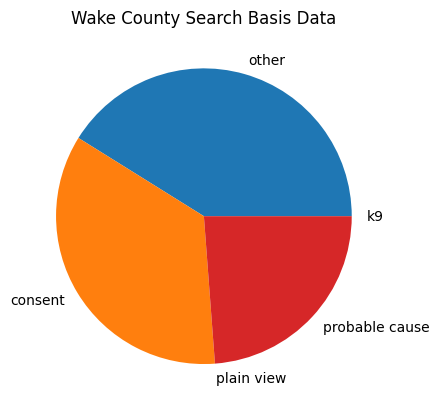

In [ ]:
wake_county = search_reasons.filter(pl.col('county_name') == 'Wake County')
labels = ['other', 'consent', 'plain view', 'probable cause', 'k9']
data = []
for label in labels:
    val = wake_county.filter(pl.col('search_basis') == label).shape[0]
    data.append(val)

plt.pie(data, labels=labels)
plt.title('Wake County Search Basis Data')

Text(0.5, 1.0, 'Guilford County Search Basis Data')

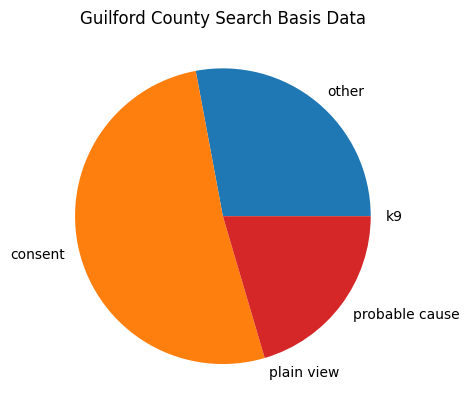

In [ ]:
guil_county = search_reasons.filter(pl.col('county_name') == 'Guilford County')
labels = ['other', 'consent', 'plain view', 'probable cause', 'k9']
data = []
for label in labels:
    val = guil_county.filter(pl.col('search_basis') == label).shape[0]
    data.append(val)

plt.pie(data, labels=labels)
plt.title('Guilford County Search Basis Data')

In [ ]:
# same for reason for frisk

search_reasons = lf.select(['county_name', 'reason_for_frisk']).drop_nulls().collect()
search_reasons


county_name,reason_for_frisk
str,str
"""Guilford County""","""Erratic/Suspicious Behavior"""
"""Guilford County""","""Erratic/Suspicious Behavior"""
"""Guilford County""","""Erratic/Suspicious Behavior"""
"""Guilford County""","""Erratic/Suspicious Behavior"""
"""Guilford County""","""Erratic/Suspicious Behavior"""
…,…
"""Guilford County""","""Erratic/Suspicious Behavior"""
"""Iredell County""","""Erratic/Suspicious Behavior|Ot…"
"""Guilford County""","""Erratic/Suspicious Behavior"""


Text(0.5, 1.0, 'Mecklenburg County Reasons for Frisk Data')

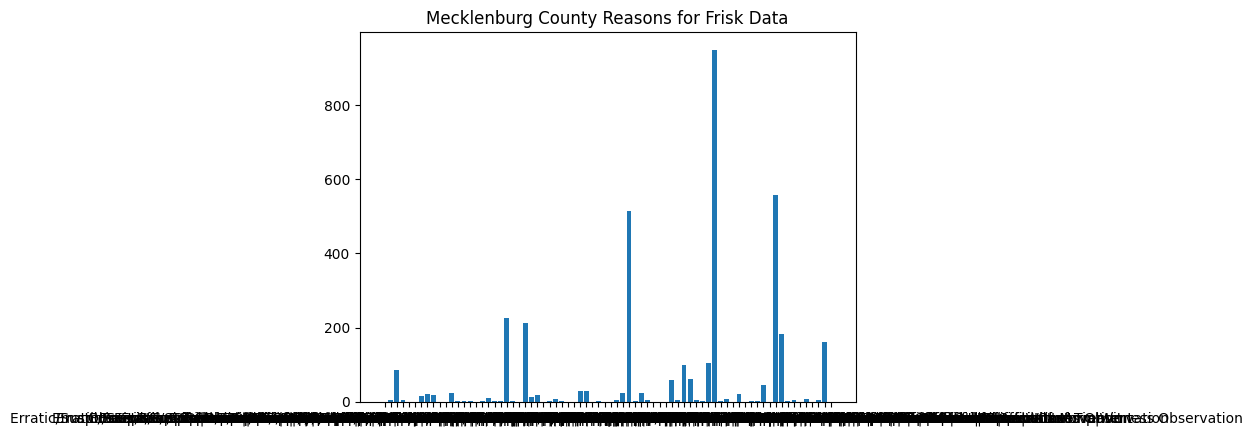

In [ ]:
meck_county = search_reasons.filter(pl.col('county_name') == 'Mecklenburg County')
labels = search_reasons.select(pl.col('reason_for_frisk').unique()).to_numpy().flatten()]
data = []
for i in range(len(labels)):
    val = meck_county.filter(pl.col('reason_for_frisk') == labels[i]).shape[0]
    data.append(val)

plt.bar(labels, data)
plt.title('Mecklenburg County Reasons for Frisk Data')

In [ ]:
meck_frisk_count = pl.DataFrame({
    'reason_for_frisk': labels,
    'count': data
})
meck_frisk_count.sort('count', descending=True)

reason_for_frisk,count
str,i64
"""Other Official Information""",949
"""Erratic/Suspicious Behavior|Su…",557
"""Erratic/Suspicious Behavior""",513
"""Erratic/Suspicious Behavior|Ot…",225
"""Erratic/Suspicious Behavior|Su…",212
…,…
"""Observation of Suspected Contr…",0
"""Other Official Information|Oth…",0
"""Suspicious Movement|Informant …",0


Text(0.5, 1.0, 'Wake County Reasons for Frisk Data')

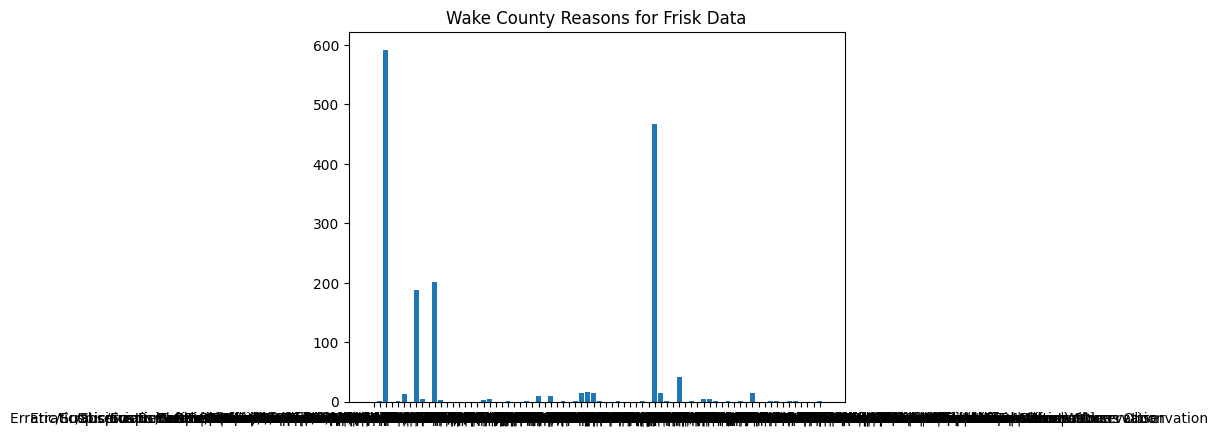

In [ ]:
wake_county = search_reasons.filter(pl.col('county_name') == 'Wake County')
labels = search_reasons.select(pl.col('reason_for_frisk').unique()).to_numpy().flatten()
data = []
for i in range(len(labels)):
    val = wake_county.filter(pl.col('reason_for_frisk') == labels[i]).shape[0]
    data.append(val)

plt.bar(labels, data)
plt.title('Wake County Reasons for Frisk Data')

In [ ]:
wake_frisk_count = pl.DataFrame({
    'reason_for_frisk': labels,
    'count': data
})
wake_frisk_count.sort('count', descending=True)

reason_for_frisk,count
str,i64
"""Erratic/Suspicious Behavior""",592
"""Other Official Information""",468
"""Suspicious Movement""",201
"""Observation of Suspected Contr…",188
"""Erratic/Suspicious Behavior|Su…",42
…,…
"""Erratic/Suspicious Behavior|Ob…",0
"""Observation of Suspected Contr…",0
"""Informant Tip|Other Official I…",0


Text(0.5, 1.0, 'Guilford County Reasons for Frisk Data')

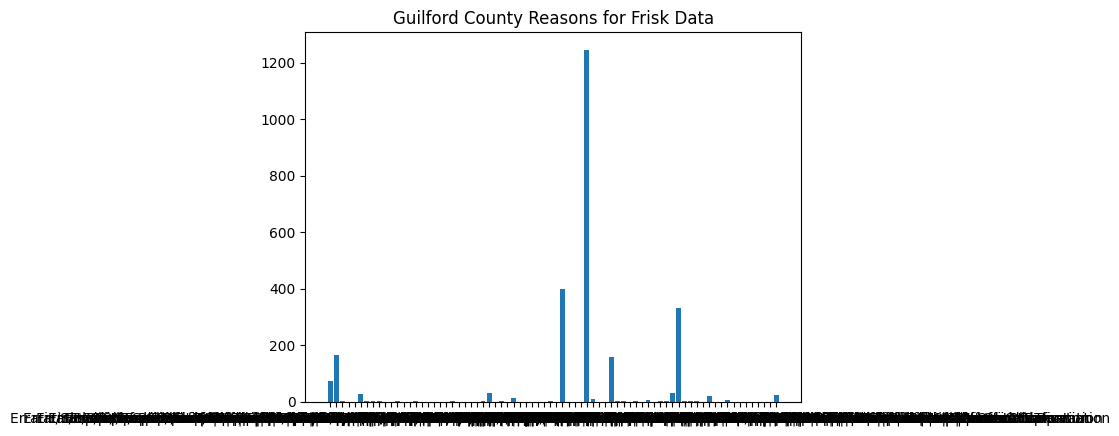

In [ ]:
guil_county = search_reasons.filter(pl.col('county_name') == 'Guilford County')
labels = search_reasons.select(pl.col('reason_for_frisk').unique()).to_numpy().flatten()
data = []
for i in range(len(labels)):
    val = guil_county.filter(pl.col('reason_for_frisk') == labels[i]).shape[0]
    data.append(val)

plt.bar(labels, data)
plt.title('Guilford County Reasons for Frisk Data')

In [ ]:
guil_frisk_count = pl.DataFrame({
    'reason_for_frisk': labels,
    'count': data
})
guil_frisk_count.sort('count', descending=True)

reason_for_frisk,count
str,i64
"""Erratic/Suspicious Behavior""",1245
"""Other Official Information""",400
"""Suspicious Movement""",332
"""Erratic/Suspicious Behavior|In…",165
"""Observation of Suspected Contr…",160
…,…
"""Observation of Suspected Contr…",0
"""Erratic/Suspicious Behavior|Ot…",0
"""Erratic/Suspicious Behavior|Su…",0


In [5]:
# can we relate the search conducted amount to race?

search_true = lf.select(['county_name', 'search_conducted', 'subject_race']).drop_nulls().collect()
meck_county = search_true.filter(pl.col('county_name') == 'Mecklenburg County')
meck_race = meck_county.group_by('subject_race').agg((pl.col('search_conducted') == 'TRUE').sum().alias('race_count')).sort('race_count', descending=True)
meck_race

subject_race,race_count
str,u32
"""black""",128379
"""white""",44706
"""hispanic""",21235
"""asian/pacific islander""",1629
"""unknown""",1073
"""other""",151


Text(0.5, 1.0, 'Mecklenburg County Searches By Race Data')

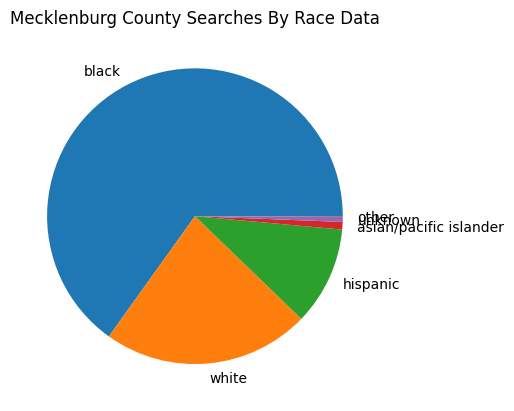

In [8]:
data = meck_race.select('race_count').to_numpy().flatten()
labels = meck_race.select('subject_race').to_numpy().flatten()

plt.pie(data, labels=labels)
plt.title('Mecklenburg County Searches By Race Data')

In [7]:
la = search_true.filter(pl.col('county_name') == 'Los Angeles')
la_race = la.group_by('subject_race').agg((pl.col('search_conducted') == 'TRUE').sum().alias('race_count')).sort('race_count', descending=True)
la_race

subject_race,race_count
str,u32
"""hispanic""",115145
"""white""",31163
"""black""",27501
"""asian/pacific islander""",9871
"""other""",9730


Text(0.5, 1.0, 'Los Angeles Searches By Race Data')

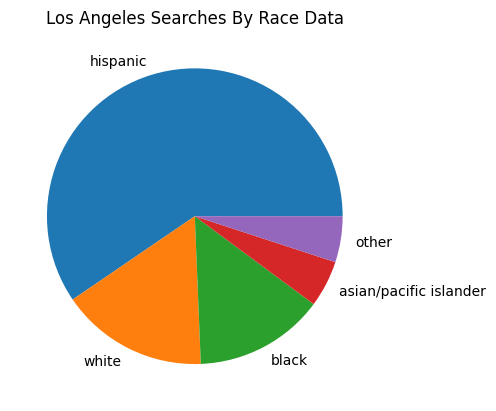

In [10]:
data = la_race.select('race_count').to_numpy().flatten()
labels = la_race.select('subject_race').to_numpy().flatten()

plt.pie(data, labels=labels)
plt.title('Los Angeles Searches By Race Data')

In [11]:
wake_county = search_true.filter(pl.col('county_name') == 'Wake County')
wake_race = wake_county.group_by('subject_race').agg((pl.col('search_conducted') == 'TRUE').sum().alias('race_count')).sort('race_count', descending=True)
wake_race

subject_race,race_count
str,u32
"""black""",49436
"""white""",31631
"""hispanic""",13466
"""asian/pacific islander""",667
"""unknown""",489
"""other""",110


Text(0.5, 1.0, 'Wake County Searches By Race Data')

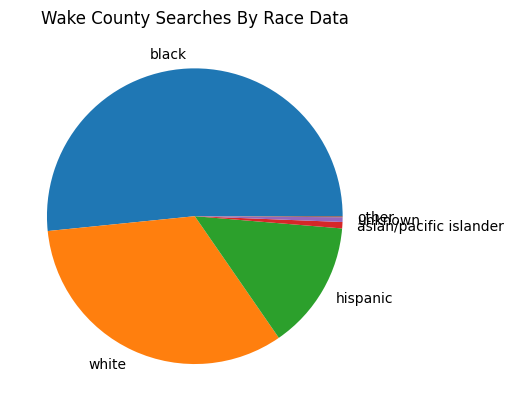

In [12]:
data = wake_race.select('race_count').to_numpy().flatten()
labels = wake_race.select('subject_race').to_numpy().flatten()

plt.pie(data, labels=labels)
plt.title('Wake County Searches By Race Data')

In [13]:
guil_county = search_true.filter(pl.col('county_name') == 'Guilford County')
guil_race = guil_county.group_by('subject_race').agg((pl.col('search_conducted') == 'TRUE').sum().alias('race_count')).sort('race_count', descending=True)
guil_race

subject_race,race_count
str,u32
"""black""",52142
"""white""",27111
"""hispanic""",6322
"""asian/pacific islander""",784
"""unknown""",504
"""other""",297


Text(0.5, 1.0, 'Guilford County Searches By Race Data')

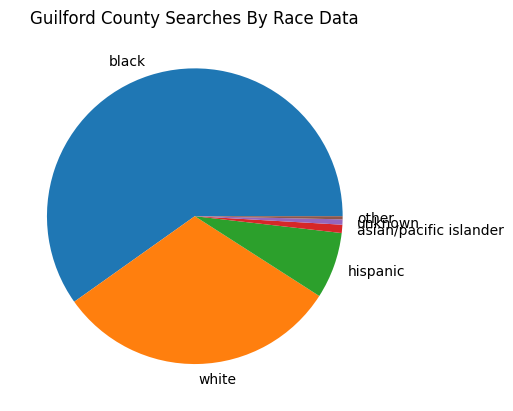

In [14]:
data = guil_race.select('race_count').to_numpy().flatten()
labels = guil_race.select('subject_race').to_numpy().flatten()

plt.pie(data, labels=labels)
plt.title('Guilford County Searches By Race Data')

In [ ]:
search_true = lf.select(['county_name', 'search_conducted', 'subject_sex']).drop_nulls().collect()
county = search_true.filter(pl.col('county_name') == 'Mecklenburg County')
sex_data = county.group_by('subject_sex').agg((pl.col('search_conducted') == 'TRUE').sum().alias('sex_count')).sort('sex_count', descending=True)
sex_data

subject_sex,sex_count
str,u32
"""male""",169324
"""female""",27399


Text(0.5, 1.0, 'Mecklenburg County Search By Sex Data')

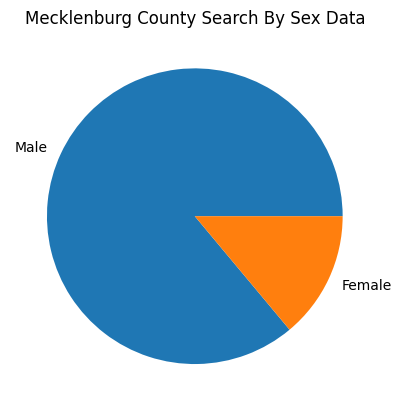

In [ ]:
data = sex_data.select('sex_count').to_numpy().flatten()
plt.pie(data, labels=['Male', 'Female'])
plt.title('Mecklenburg County Search By Sex Data')

In [22]:
county = search_true.filter(pl.col('county_name') == 'Los Angeles')
sex_data = county.group_by('subject_sex').agg((pl.col('search_conducted') == 'TRUE').sum().alias('sex_count')).sort('sex_count', descending=True)
sex_data

subject_sex,sex_count
str,u32
"""male""",149220
"""female""",44188


Text(0.5, 1.0, 'Los Angeles Search By Sex Data')

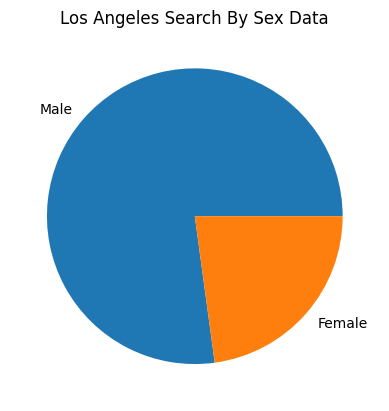

In [23]:
data = sex_data.select('sex_count').to_numpy().flatten()
plt.pie(data, labels=['Male', 'Female'])
plt.title('Los Angeles Search By Sex Data')

Text(0.5, 1.0, 'Wake County Search By Sex Data')

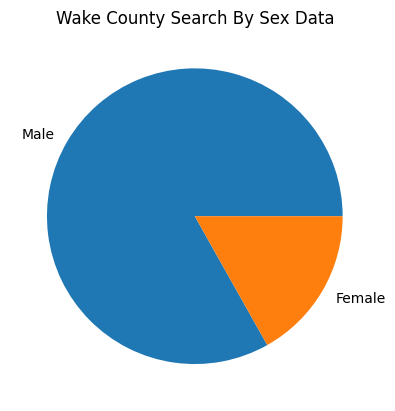

In [28]:
county = search_true.filter(pl.col('county_name') == 'Wake County')
sex_data = county.group_by('subject_sex').agg((pl.col('search_conducted') == 'TRUE').sum().alias('sex_count')).sort('sex_count', descending=True)
data = sex_data.select('sex_count').to_numpy().flatten()

plt.pie(data, labels=['Male', 'Female'])
plt.title('Wake County Search By Sex Data')

Text(0.5, 1.0, 'Guilford County Search By Sex Data')

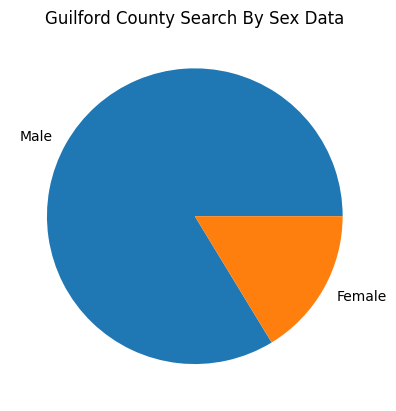

In [29]:
county = search_true.filter(pl.col('county_name') == 'Guilford County')
sex_data = county.group_by('subject_sex').agg((pl.col('search_conducted') == 'TRUE').sum().alias('sex_count')).sort('sex_count', descending=True)
data = sex_data.select('sex_count').to_numpy().flatten()

plt.pie(data, labels=['Male', 'Female'])
plt.title('Guilford County Search By Sex Data')